In [64]:
%matplotlib inline
import torch
import numpy as np
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

# 人工生成数据集
给定样本x，用以下三阶多项式函数生成该样本的标签：

$$ y=1.2 x-3.4 x^{2}+5.6 x^{3}+5+\epsilon $$

In [85]:
n_train, n_test, true_w, true_b = 100,100,[1.2,-3.4,5.6],5

# 1.线性函数
features = torch.randn((n_train + n_test, 1))

# 2.多次项函数（相当于做变量替换：a=x，b=x2，c=x3）
# torch.cat((A,B),1)：将按列将张量A和B拼接在一起
poly_features = torch.cat((features, torch.pow(features,2),torch.pow(features, 3)), 1)

labels = (true_w[0] * poly_features[:,0] + true_w[1] * poly_features[:,1]
         + true_w[2] * poly_features[:,2] + true_b)

labels += torch.tensor(np.random.normal(0,0.01,size=labels.size()), dtype=torch.float)


In [66]:
# 看看训练集的前两个样本
print(features[:2])
print(poly_features[:2])

tensor([[-0.4043],
        [ 0.5165]])
tensor([[-0.4043,  0.1635, -0.0661],
        [ 0.5165,  0.2668,  0.1378]])


In [67]:
print(features.shape)
print(features.shape[-1])

torch.Size([200, 1])
1


# 定义、训练和测试模型

In [68]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用

# y轴采用对数尺度
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)


In [69]:
num_epochs = 100
loss = torch.nn.MSELoss()

In [70]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    # Linear() 参数： 
    net = torch.nn.Linear(train_features.shape[-1], 1) # ?
#     print('train_features.shape[-1]:',train_features.shape[-1])

    batch_size = min(10,train_labels.shape[0]) 
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle = True)
    
    optimizer = torch.optim.SGD(net.parameters(),lr = 0.01)
    train_ls, test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y.view(-1,1)) #?
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features), train_labels).item() )
        test_ls.append(loss(net(test_features), test_labels).item() )
    print('final epoch: train loss', train_ls[-1],'test loss', test_ls[-1])
    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
            range(1, num_epochs +1), test_ls, ['train','test'])
    print('weight:',net.weight.data)
    print('\nbias:',net.bias.data)

# 三阶多项式拟合（正常）

final epoch: train loss 0.00010176152864005417 test loss 8.251875988207757e-05
weight: tensor([[ 1.2017, -3.3994,  5.5994]])

bias: tensor([4.9997])


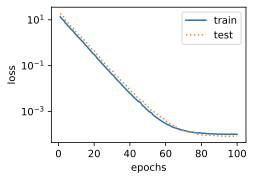

In [80]:
# 参数： 训练集样本、测试集样本；训练标签、测试标签
fit_and_plot(poly_features[:n_train,:], poly_features[n_train:,:],
            labels[:n_train], labels[n_train:])

# 线性函数拟合（欠拟合）
该模型的训练误差在迭代早期下降后便很难继续降低。在完成最后一次迭代周期后，训练误差依旧很高。

final epoch: train loss 401.2947692871094 test loss 211.0944366455078
weight: tensor([[20.5986]])

bias: tensor([0.8053])


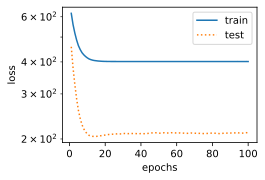

In [87]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

# 训练样本不足（过拟合）
训练样本过少，甚至少于模型参数的数量。这使得模型过于复杂，以至于容易被训练数据中的噪声影响。

在迭代过程中，尽管训练误差较低，但是测试数据集上的误差却很高。这是典型的过拟合现象。

final epoch: train loss 0.49686768651008606 test loss 595.702880859375
weight: tensor([[0.8297, 1.1109, 0.1197]])

bias: tensor([3.7473])


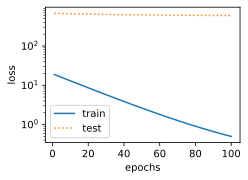

In [79]:
fit_and_plot(poly_features[0:2,:], poly_features[n_train:,:],
            labels[0:2], labels[n_train:])